In [17]:
import sys

sys.path.insert(0, '/Users/egork/.pyenv/versions/3.6.7/lib/python3.6/site-packages/')
%matplotlib inline

from scipy.io import loadmat
import pandas as pd

import matplotlib.pyplot as plt
import seaborn
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
import time
from sklearn.preprocessing import minmax_scale
from random import sample
from random import seed
from sklearn.preprocessing import minmax_scale, LabelEncoder
from sklearn.utils.multiclass import type_of_target
epsilon = 10**(-8)

In [7]:
import glob
data_files = glob.glob('./data/*.mat')
print(data_files)

['./data/pima.mat', './data/arrhythmia.mat', './data/shuttle.mat', './data/thyroid.mat', './data/breastw.mat', './data/satellite.mat', './data/annthyroid.mat', './data/ionosphere.mat', './data/smtp.mat', './data/mammography.mat']


In [8]:
def read_data(file_name):
    print(file_name)
    data = loadmat(file_name)
    return data['X'], data['y']

In [9]:
file_name = './data/ionosphere.mat'
x = loadmat(file_name)
features, label = read_data(file_name)

./data/ionosphere.mat


In [10]:
features.shape[0]*0.04

14.040000000000001

In [11]:
features.shape

(351, 33)

In [12]:
print(pd.DataFrame(features).nunique().values)
print(pd.DataFrame(features).nunique().values/features.shape[0])

[  2 219 269 204 259 231 260 244 267 246 269 238 266 234 270 254 280 254
 266 248 265 248 264 256 273 256 281 244 266 243 263 245 263]
[0.00569801 0.62393162 0.76638177 0.58119658 0.73789174 0.65811966
 0.74074074 0.6951567  0.76068376 0.7008547  0.76638177 0.67806268
 0.75783476 0.66666667 0.76923077 0.72364672 0.7977208  0.72364672
 0.75783476 0.70655271 0.75498575 0.70655271 0.75213675 0.72934473
 0.77777778 0.72934473 0.8005698  0.6951567  0.75783476 0.69230769
 0.74928775 0.6980057  0.74928775]


In [13]:
min_leaf_size, n_trees = 14, 500

In [14]:
forest_parameters = dict(n_estimators=n_trees, criterion='mse', max_features=0.333333,
                        oob_score=True, verbose=1, n_jobs=-1,  min_samples_leaf=min_leaf_size)

In [15]:
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.metrics import explained_variance_score

def _set_oob_error(estimators_, X, y):
    """
    Compute out-of-bag variance."""

    n_samples = y.shape[0]

    predictions = [[] for _ in range(n_samples)]
    n_predictions = np.zeros((n_samples, 1))

    n_samples_bootstrap = n_samples

    for estimator in estimators_:
        unsampled_indices = _generate_unsampled_indices(
            estimator.random_state, n_samples, n_samples_bootstrap)
        p_estimator = estimator.predict(
            X[unsampled_indices, :], check_input=False)


        p_estimator = p_estimator[:, np.newaxis]
        for idx, value in enumerate(unsampled_indices):
            predictions[value].append(p_estimator[idx])
    return np.array([np.sum(((values - y[idx])**2)/len(values)) for idx, values in enumerate(predictions)])


def _set_oob_variance(estimators_, X, y):
    """
    Compute out-of-bag variance."""

    n_samples = y.shape[0]

    predictions = [[] for _ in range(n_samples)]
    n_predictions = np.zeros((n_samples, 1))

    n_samples_bootstrap = n_samples

    for estimator in estimators_:
        unsampled_indices = _generate_unsampled_indices(
            estimator.random_state, n_samples, n_samples_bootstrap)
        p_estimator = estimator.predict(
            X[unsampled_indices, :], check_input=False)


        p_estimator = p_estimator[:, np.newaxis]

        for idx, value in enumerate(unsampled_indices):
            predictions[value].append(p_estimator[idx].tolist()[0])
    return np.array([np.var(arr) for arr in predictions])


def compute_metric_single_feature(features, feature_index):
    print("Continious appraoch feature {}".format(feature_index))
    results_pd = pd.DataFrame()

    regressor=RandomForestRegressor(**forest_parameters)
    
    
    y=features[:, feature_index]    
    train=np.delete(features, [feature_index], axis=1)
    start_time = time.time()
    regressor.fit(X=train, y=y)
    print("--- %s seconds fit ---" % (time.time() - start_time))


    predictions = regressor.oob_prediction_
    
    results_pd['prediction_{}'.format(feature_index)] = pd.Series(np.array(predictions)[:])
    np_log=np.log(np.abs((np.array(predictions)[:]+epsilon)/(y+epsilon)))
    abs_diff = np.abs(np.array(predictions)[:] - y) + epsilon
    results_pd['abs_diff_{}'.format(feature_index)] = pd.Series(abs_diff)
    results_pd['abs_diff_min_max_scaling_{}'.format(feature_index)] = pd.Series(minmax_scale(abs_diff, feature_range=(epsilon, 1)))

    results_pd['abs_diff_median_scaling_{}'.format(feature_index)] = pd.Series(minmax_scale(_set_oob_error(regressor.estimators_, np.array(train, dtype=np.float32), y)))
    results_pd['log_ratio_{}'.format(feature_index)] = pd.Series(np_log)
    results_pd['log_abs_ratio_{}'.format(feature_index)] = pd.Series(np.abs(np_log))
    feature_imp = np.insert(regressor.feature_importances_, feature_index, 0,axis=0)
    weight = 1 - min(1, (1 - metrics.r2_score(y, np.array(predictions)[:],
                                              multioutput='raw_values'))**0.5)
    print("Weight: {}".format(weight))
    results_pd['weighted_abs_diff_median_scaling_{}'.format(feature_index)] =  weight * pd.Series(abs_diff/(np.median(abs_diff)+epsilon))
    return results_pd

def compute_metrics_single_categorical_feature(features, feature_index, bin_number=None):
    print("Categorical appraoch feature {}".format(feature_index))
    results_pd = pd.DataFrame()
    classifier = RandomForestClassifier(oob_score=True, 
                                        n_estimators=n_trees, bootstrap=True, n_jobs=-1,
                                        criterion='entropy', min_samples_leaf=min_leaf_size, verbose=1)

    y=features[:, feature_index]
    if bin_number or type_of_target(features[:, feature_index])=='continuous':
        if bin_number:
            bins = min(np.unique(y).shape[0], bin_number)
        else:
            bins = np.unique(y).shape[0]
        y = np.digitize(y, bins=np.histogram(y, bins=bins)[1])
    train=np.delete(features, [feature_index], axis=1)
    start_time = time.time()
    
    classifier.fit(X=train, y=y)
    print("--- %s seconds fit ---" % (time.time() - start_time))

    y_map={value: list(set(y.flatten())).index(value)  for value in set(y.flatten())}

    probability_scores=[classifier.oob_decision_function_[index,:][y_map[element]] for index, element in enumerate(y.flatten())]
    
    entropy_list=[]
    num_classes=np.unique(y).shape[0]
    if num_classes>1:
        max_entropy = np.log(num_classes)
    else:
        max_entropy = 1
    #__import__('pdb').set_trace()
    entropy_np = np.array([sum([-value*np.log(value+epsilon) for value in ls])/max_entropy + (1.0-probability_scores[idx]) for idx, ls in enumerate(classifier.oob_decision_function_)])
    results_pd["abs_diff_median_scaling_{}".format(feature_index)] = minmax_scale(pd.Series(entropy_np))
    return results_pd

In [19]:
## Average forest

results_all_features_pd = pd.DataFrame()
feature_weights=np.zeros(features.shape[1])
feature_weights_r2=[]
min_number_of_values = 100
num_feature_index = [feature_index for feature_index in range(features.shape[1])
                     if len(set(features[:, feature_index])) > 0]
bin_number = None
for feature_index in num_feature_index:
    print('--- feature index {} / {} ---'.format(feature_index, features.shape[1]-1))
    if len(set(features[:, feature_index])) > min_number_of_values:
        results_pd = compute_metric_single_feature(features, feature_index)
    else:
        results_pd = compute_metrics_single_categorical_feature(features, feature_index, bin_number)
 
    results_all_features_pd[results_pd.columns] = results_pd


--- feature index 0 / 32 ---
Categorical appraoch feature 0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4326059818267822 seconds fit ---
--- feature index 1 / 32 ---
Continious appraoch feature 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2606971263885498 seconds fit ---
Weight: [0.23025508]
--- feature index 2 / 32 ---
Continious appraoch feature 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.138390064239502 seconds fit ---
Weight: [0.12458387]
--- feature index 3 / 32 ---
Continious appraoch feature 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1262907981872559 seconds fit ---
Weight: [0.30187257]
--- feature index 4 / 32 ---
Continious appraoch feature 4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3079800605773926 seconds fit ---
Weight: [0.15666439]
--- feature index 5 / 32 ---
Continious appraoch feature 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1742539405822754 seconds fit ---
Weight: [0.34146336]
--- feature index 6 / 32 ---
Continious appraoch feature 6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2469708919525146 seconds fit ---
Weight: [0.21207228]
--- feature index 7 / 32 ---
Continious appraoch feature 7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.218583106994629 seconds fit ---
Weight: [0.37237111]
--- feature index 8 / 32 ---
Continious appraoch feature 8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.271958589553833 seconds fit ---
Weight: [0.18707346]
--- feature index 9 / 32 ---
Continious appraoch feature 9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.237044095993042 seconds fit ---
Weight: [0.4122389]
--- feature index 10 / 32 ---
Continious appraoch feature 10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1929879188537598 seconds fit ---
Weight: [0.19383261]
--- feature index 11 / 32 ---
Continious appraoch feature 11


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3072888851165771 seconds fit ---
Weight: [0.46214554]
--- feature index 12 / 32 ---
Continious appraoch feature 12


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1943588256835938 seconds fit ---
Weight: [0.17308759]
--- feature index 13 / 32 ---
Continious appraoch feature 13


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1376619338989258 seconds fit ---
Weight: [0.53927391]
--- feature index 14 / 32 ---
Continious appraoch feature 14


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1585180759429932 seconds fit ---
Weight: [0.19470194]
--- feature index 15 / 32 ---
Continious appraoch feature 15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.152189016342163 seconds fit ---
Weight: [0.45133751]
--- feature index 16 / 32 ---
Continious appraoch feature 16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


--- 1.1391069889068604 seconds fit ---
Weight: [0.17879679]
--- feature index 17 / 32 ---
Continious appraoch feature 17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1693320274353027 seconds fit ---
Weight: [0.42137447]
--- feature index 18 / 32 ---
Continious appraoch feature 18


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


--- 1.1405291557312012 seconds fit ---
Weight: [0.25079184]
--- feature index 19 / 32 ---
Continious appraoch feature 19


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.2117838859558105 seconds fit ---
Weight: [0.45948739]
--- feature index 20 / 32 ---
Continious appraoch feature 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1573190689086914 seconds fit ---
Weight: [0.25842562]
--- feature index 21 / 32 ---
Continious appraoch feature 21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


--- 1.1498758792877197 seconds fit ---
Weight: [0.3637617]
--- feature index 22 / 32 ---
Continious appraoch feature 22


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.238832712173462 seconds fit ---
Weight: [0.19202859]
--- feature index 23 / 32 ---
Continious appraoch feature 23


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2398669719696045 seconds fit ---
Weight: [0.33188163]
--- feature index 24 / 32 ---
Continious appraoch feature 24


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1578989028930664 seconds fit ---
Weight: [0.22289279]
--- feature index 25 / 32 ---
Continious appraoch feature 25


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2887580394744873 seconds fit ---
Weight: [0.3309711]
--- feature index 26 / 32 ---
Continious appraoch feature 26


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.225283145904541 seconds fit ---
Weight: [0.19666423]
--- feature index 27 / 32 ---
Continious appraoch feature 27


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.2468750476837158 seconds fit ---
Weight: [0.32425739]
--- feature index 28 / 32 ---
Continious appraoch feature 28


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1428089141845703 seconds fit ---
Weight: [0.20202931]
--- feature index 29 / 32 ---
Continious appraoch feature 29


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1606640815734863 seconds fit ---
Weight: [0.31165233]
--- feature index 30 / 32 ---
Continious appraoch feature 30


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1089282035827637 seconds fit ---
Weight: [0.22999665]
--- feature index 31 / 32 ---
Continious appraoch feature 31


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2563910484313965 seconds fit ---
Weight: [0.40834524]
--- feature index 32 / 32 ---
Continious appraoch feature 32


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1394920349121094 seconds fit ---
Weight: [0.2376989]


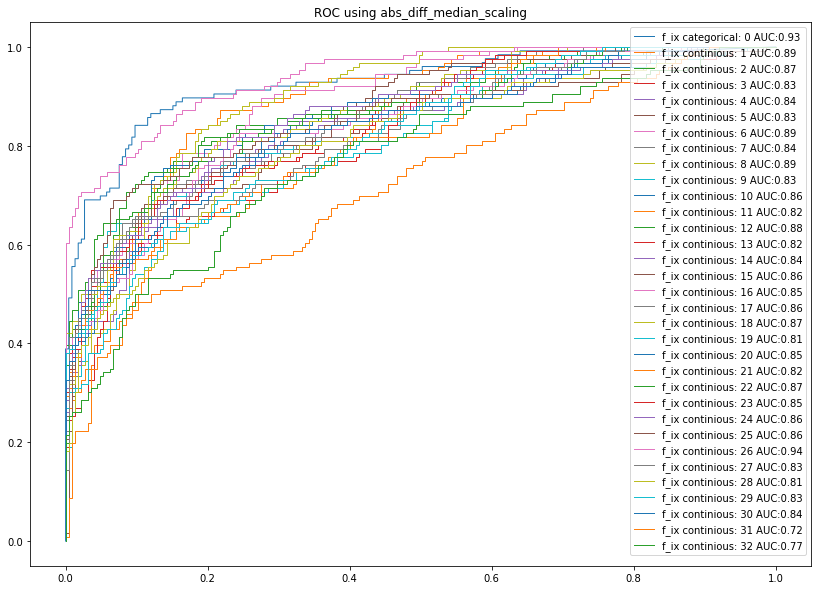

0.9407407407407407


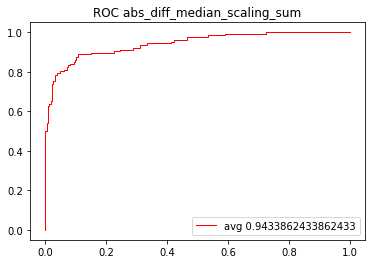

In [20]:
metric_name = 'abs_diff_median_scaling'
plt.figure(figsize=[14, 10])
auc=[]
columns_list_names=['{}_{}'.format(metric_name, feature_index) for feature_index in num_feature_index]

for feature_index in num_feature_index:
    fpr, tpr, thresholds = metrics.roc_curve(label.flatten(),
                                             results_all_features_pd['{}_{}'.format(metric_name, feature_index )],
                                             pos_label=1)
    if len(set(features[:, feature_index])) > min_number_of_values:
        message = "f_ix continious: {} AUC:{:.2}".format(feature_index, metrics.auc(fpr, tpr))
    else:
        message = "f_ix categorical: {} AUC:{:.2}".format(feature_index, metrics.auc(fpr, tpr))
    plt.plot(fpr, tpr, lw=1, label=message,
             color='C{}'.format(feature_index%10))
    plt.title("ROC using {}".format(metric_name))
    auc.append(metrics.auc(fpr, tpr))
plt.legend()
plt.show()
print(max(auc))

# simple sum
metric_sum =(results_all_features_pd[columns_list_names]).sum(axis=1)
fpr1, tpr1, thresholds1 = metrics.roc_curve(label.flatten(), metric_sum, pos_label=1)
plt.plot(fpr1, tpr1, color='red', lw=1, label='avg {}'.format(metrics.auc(fpr1, tpr1)))
plt.title("ROC {}_sum".format(metric_name))
plt.legend()
plt.show()